# Adversarial examples with projected gradient descent and box-contrained L-BFGS

This notebook shows an example of how to use the provided code to attack an object classification model.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
batch_shape = [None, 299, 299, 3]

In [3]:
# Code to instantiate an inception model; pre-process images and revert the pre-processing (e.g. for visualization)

from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim

class InceptionModel:  
    def __init__(self, end_point='Logits'):
        self.initialized = False
        self.end_point = end_point
        self.num_classes=1001
        
    def __call__(self, x_input):
        if self.initialized:
            reuse = True
        else:
            reuse = False
            self.initialized = True
            
        with slim.arg_scope(inception.inception_v3_arg_scope()):
              _, end_points = inception.inception_v3(
                  x_input, num_classes=self.num_classes, is_training=False, reuse=reuse)
        
        return end_points[self.end_point]
    
def preprocess_image(img):
    return img / 127.5 - 1

def revert_processed_image(img):
    return ((img + 1) * 127.5 ).astype(np.uint8)

In [4]:
# Instantiate the model

tf.reset_default_graph()
x_input = tf.placeholder(tf.float32, shape=batch_shape)
y_input = tf.placeholder(tf.int32, shape=(batch_shape[0]))

model = InceptionModel()
logits = model(x_input)
probs = tf.nn.softmax(logits)
prediction = tf.argmax(logits, axis=1)

In [5]:
# Download the weights (if not yet done)
model_path = 'inception_v3.ckpt'

if not os.path.exists(model_path):
    import urllib
    import tarfile 
    compressed_path = 'inception_v3_2016_08_28.tar.gz'
    
    print('Downloading model')
    
    urllib.urlretrieve('http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz', compressed_path)
       
    with tarfile.open(zip_path, 'r') as compressed_model:
        compressed_model.extractall()
    os.unlink(compressed_path)
    print('Done')

In [6]:
# Load the pre-trained weights

saver = tf.train.Saver(slim.get_model_variables())
sess = tf.InteractiveSession()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from inception_v3.ckpt


In [7]:
# Load some sample images

from scipy.misc import imread, imsave

img_names = ['images/panda.png', 'images/flag.png']
labels = np.array([389, 558])

imgs = [preprocess_image(imread(f)) for f in img_names]
imgs = np.stack(imgs)
pred, original_probabilities = sess.run([prediction, probs], feed_dict={x_input: imgs})

assert np.all(labels == pred)

with open('imagenet_labels.txt') as f:
    class_names = [line.strip() for line in f.readlines()]
class_names = np.array(class_names)

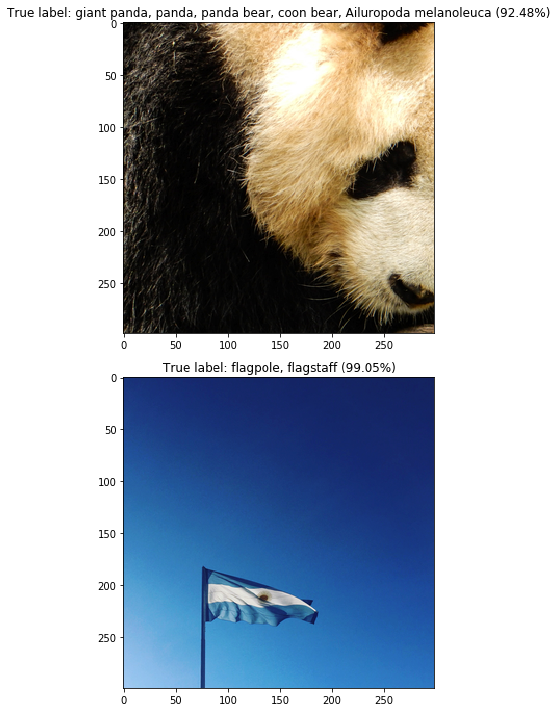

In [8]:
# Let's take a look on the original images

f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(imgs):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    ax[i].set_title('True label: %s (%.2f%%)' % (class_names[true_class], original_probabilities[i, true_class] * 100))
f.tight_layout()

## Runing the attacks

In [9]:
import pgd_attack # Projected SGD attack
import step_pgd_attack # Step FGMS + projected SGD
import box_constrained_attack # Box constrained L-BFGS attack

In [10]:
# Define some parameters for the attacks:

max_epsilon = 8  # Max epsilon on the original range (0 to 255)
max_iter = 30 # Maximun number of iterations
eps = 2.0 * max_epsilon / 255.0 # Max epsilon on the range of the processed images (-1 to 1)

In [11]:
# First example: Generating non-targeted attacks using the PGD attack

pgd_attacker = pgd_attack.PGD_attack(model, 
                                     batch_shape, 
                                     max_epsilon=eps, 
                                     max_iter=max_iter, 
                                     targeted=False,
                                     initial_lr=1,
                                     lr_decay=0.99)

In [12]:
attack_img = pgd_attacker.generate(sess, imgs, pred, verbose=True)

Iter 0, loss: 10.94
Iter 1, loss: 4.69
Iter 2, loss: 0.32
Iter 3, loss: -1.47
Iter 4, loss: -2.55
Iter 5, loss: -2.50
Iter 6, loss: -3.55
Iter 7, loss: -3.78
Iter 8, loss: -4.05
Iter 9, loss: -4.02
Iter 10, loss: -4.41
Iter 11, loss: -4.33
Iter 12, loss: -4.34
Iter 13, loss: -5.03
Iter 14, loss: -5.13
Iter 15, loss: -5.40
Iter 16, loss: -6.42
Iter 17, loss: -6.30
Iter 18, loss: -6.34
Iter 19, loss: -6.20
Iter 20, loss: -6.38
Iter 21, loss: -7.72
Iter 22, loss: -7.04
Iter 23, loss: -7.80
Iter 24, loss: -8.17
Iter 25, loss: -8.07
Iter 26, loss: -7.86
Iter 27, loss: -8.37
Iter 28, loss: -8.12
Iter 29, loss: -9.20


In [13]:
adv_prediction, adv_probabilities = sess.run([prediction, probs], feed_dict={x_input: attack_img, y_input: labels})

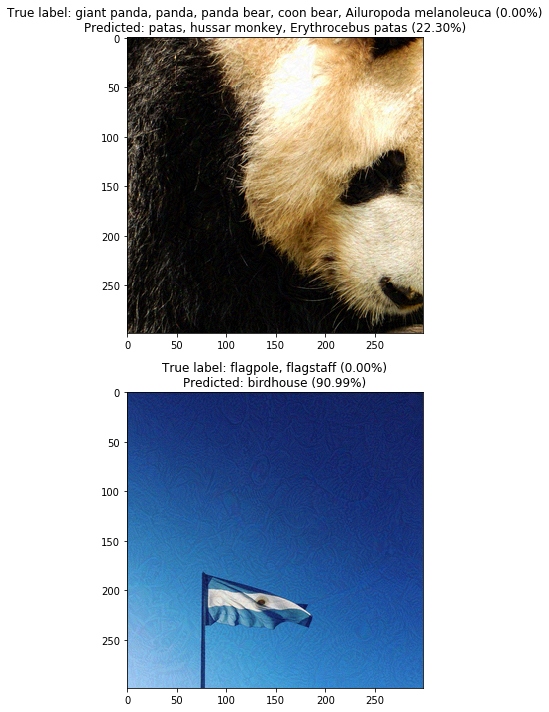

In [14]:
f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(attack_img):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    pred_class = adv_prediction[i]
    title = 'True label: %s (%.2f%%)' % (class_names[true_class], adv_probabilities[i, true_class] * 100)
    title += '\nPredicted: %s (%.2f%%)' % (class_names[pred_class], adv_probabilities[i, pred_class] * 100)
    ax[i].set_title(title)
f.tight_layout()

In [15]:
# 2nd example: targeted attack using box 
lbfgs_attacker = box_constrained_attack.box_constrained_attack(model, 
                                                                batch_shape, 
                                                                max_epsilon=eps,
                                                                max_iter=max_iter, 
                                                                targeted=True)

attack_img = lbfgs_attacker.generate(sess, imgs, [1, 1], verbose=True) # Note: the log is written on the ipython stdout


In [16]:
adv_prediction, adv_probabilities = sess.run([prediction, probs], feed_dict={x_input: attack_img})

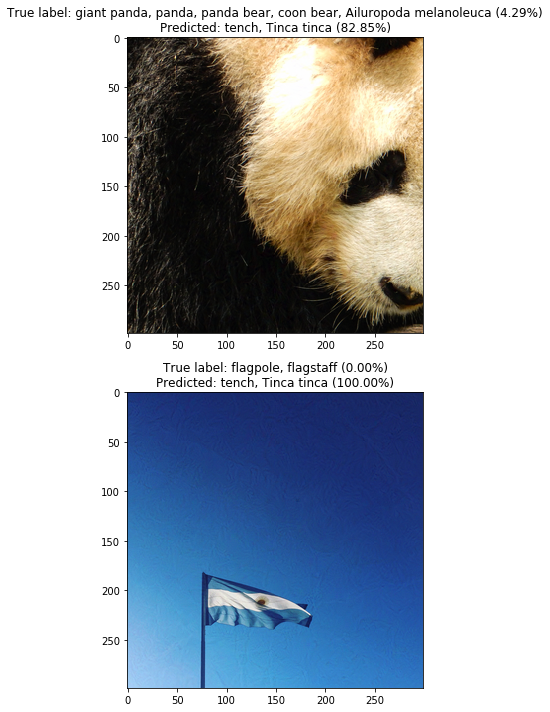

In [17]:
f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(attack_img):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    pred_class = adv_prediction[i]
    title = 'True label: %s (%.2f%%)' % (class_names[true_class], adv_probabilities[i, true_class] * 100)
    title += '\nPredicted: %s (%.2f%%)' % (class_names[pred_class], adv_probabilities[i, pred_class] * 100)
    ax[i].set_title(title)
f.tight_layout()

In [18]:
# 3rd example: targeted attack using step FGSM + PGD 

step_pgd_attacker = step_pgd_attack.step_pgd_attack(model, 
                                     batch_shape, 
                                     max_epsilon=eps, 
                                     max_iter=max_iter, 
                                     targeted=True,
                                     initial_lr=1,
                                     lr_decay=0.99,
                                     alpha=eps/2,
                                     step_iter=5)

attack_img = step_pgd_attacker.generate(sess, imgs, [1, 1], verbose=True)


Iter 0, loss: -0.43
Iter 1, loss: 0.38
Iter 2, loss: 1.01
Iter 3, loss: 1.60
Iter 4, loss: 2.23
Iter 5, loss: 1.99
Iter 6, loss: 4.27
Iter 7, loss: 5.54
Iter 8, loss: 6.08
Iter 9, loss: 6.53
Iter 10, loss: 9.07
Iter 11, loss: 7.76
Iter 12, loss: 10.51
Iter 13, loss: 10.13
Iter 14, loss: 11.45
Iter 15, loss: 11.73
Iter 16, loss: 15.34
Iter 17, loss: 14.32
Iter 18, loss: 9.07
Iter 19, loss: 12.13
Iter 20, loss: 16.69
Iter 21, loss: 17.17
Iter 22, loss: 15.30
Iter 23, loss: 13.04
Iter 24, loss: 14.27
Iter 25, loss: 19.28
Iter 26, loss: 15.01
Iter 27, loss: 17.94
Iter 28, loss: 19.84
Iter 29, loss: 16.88


In [19]:
adv_prediction, adv_probabilities = sess.run([prediction, probs], feed_dict={x_input: attack_img})

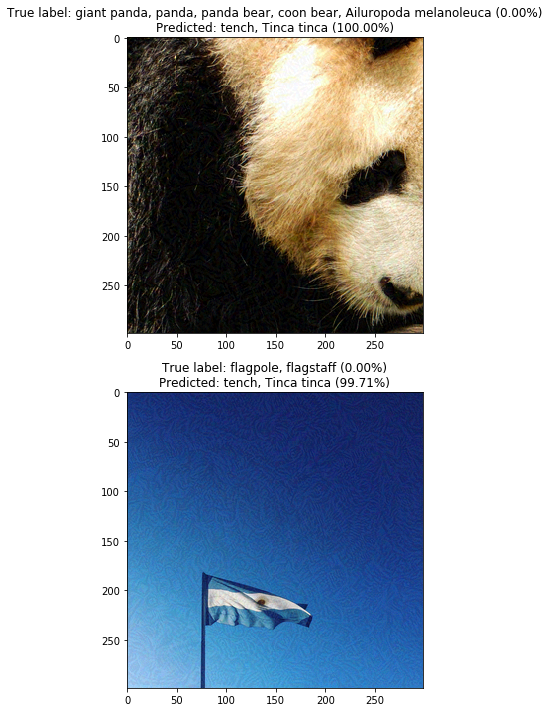

In [20]:
f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(attack_img):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    pred_class = adv_prediction[i]
    title = 'True label: %s (%.2f%%)' % (class_names[true_class], adv_probabilities[i, true_class] * 100)
    title += '\nPredicted: %s (%.2f%%)' % (class_names[pred_class], adv_probabilities[i, pred_class] * 100)
    ax[i].set_title(title)
f.tight_layout()